In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
MAX_INPUT_SIZE = 2*512
IMG_HEIGHT = 256
IMG_WIDTH = 256


In [10]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)

    if tf.shape(image)[0]>MAX_INPUT_SIZE:
        image = tf.image.resize(image, [MAX_INPUT_SIZE, 3 * MAX_INPUT_SIZE], preserve_aspect_ratio=True)        
    elif tf.shape(image)[0]<IMG_WIDTH:
        image = tf.image.resize(image, [IMG_WIDTH, 3 * IMG_WIDTH], preserve_aspect_ratio=True)        

    w = tf.shape(image)[1]

    w = w // 3
    if w<IMG_WIDTH:
        w=IMG_WIDTH
    image = tf.image.resize(image, [3 * w, 3 * w], preserve_aspect_ratio=True) 
    
    #image = tf.image.resize(image, [tf.shape(image)[0], 3 * w])

    real_image = image[:, :w, :]
    input_image = image[:, w:2*w, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image


def normalize(input_image, real_image):
    real_image = tf.image.rgb_to_grayscale(real_image)
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image


def resize(input_image, real_image):
    img_size_in = tf.shape(input_image)
    img_sizeI = tf.cast(img_size_in, tf.float32)
    if img_sizeI[0] % 256 or img_sizeI[1] % 256:
        img_size = (
            256 * tf.math.ceil(img_sizeI[0] / 256),
            256 * tf.math.ceil(img_sizeI[1] / 256),
        )
    else:
        img_size = (
            256 * tf.math.ceil(img_sizeI[0] / 256),
            256 * tf.math.ceil(img_sizeI[1] / 256),
        )
    diffx = tf.cast(img_size[0] - img_sizeI[0], tf.int32)
    diffy = tf.cast(img_size[1] - img_sizeI[1], tf.int32)
    paddings = [[0, diffx], [0, diffy], [0, 0]]
    paddings = tf.cast(paddings, tf.int32)
    input_image = tf.pad(input_image, paddings, "REFLECT")
    real_image = tf.pad(real_image, paddings, "REFLECT")

    """
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    """
    return input_image, real_image, img_size_in


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]
    )

    return cropped_image[0], cropped_image[1]


@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    # input_image, real_image = resize(input_image, real_image, 512, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_val(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image, img_size_in = resize(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image, img_size_in = resize(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image, img_size_in

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


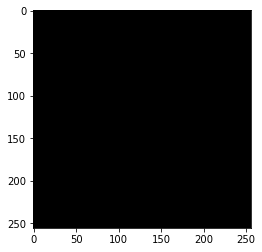

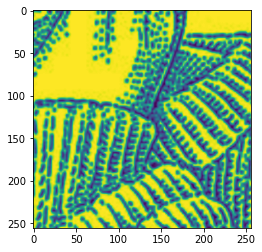

In [11]:
import numpy as np
PATH = '../Datasets/headcuts/ABC/train/0001.png'

inp, re = load_image_train(PATH)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(np.squeeze(re)/255.0)